# Global Params

In [183]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import math
from tqdm import tqdm
import shutil
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from torchvision import transforms
import tifffile as tiff
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [184]:
"""
Global parameters for the UNet model defined here for easy access across files.
"""
# Copied from COMP3710 report

# Hyperparameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 30
NUM_WORKERS = 4
PIN_MEMORY = True
# PREDICTION_THRESHOLD = 0.5
PREDICTION_THRESHOLD = 0.99

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

HIGH_PASS_ALPHA = 0.1
HIGH_PASS_STRENGTH = 0.1

TILE_SIZE = 512

TILES_IN_X = 4
TILES_IN_Y = 5

test_dir = '/kaggle/input/blood-vessel-segmentation/test'
IS_LOCAL = not os.path.exists(test_dir)
IS_SUBMISSION = (not IS_LOCAL) and len(glob(test_dir+"/kidney_5/images/*.tif"))!=3

CHECKPOINT_DIR = '../../checkpoints/checkpoint.pth.tar'
VAL_DATASET_DIR = '../../data/train/kidney_2'

# base_path = 'data/train'
base_path = 'data_downsampled512/train'
# dataset = 'kidney_1_dense'
datasets = ['kidney_1_dense', 'kidney_1_voi', 'kidney_2', 'kidney_3_sparse']

# Dataset

In [185]:
"""
Code copied from https://www.kaggle.com/code/aniketkolte04/sennet-hoa-seg-pytorch-attention-gated-unet
pytorch dataset for the challenge.
"""
class CustomDataset(Dataset):
    def __init__(self, image_files, mask_files, 
                 input_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
                 augmentation_transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)

        if self.augmentation_transforms:
            image, mask = self.augmentation_transforms(image, mask)

        return image, mask

class UsageDataset(Dataset):
    def __init__(self, image_files, 
                 input_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
                 augmentation_transforms=None):
        self.image_files = image_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       
        image_path = self.image_files[idx]

        image, orig_size = preprocess_image(image_path, return_size=True)
        # orig_size = image.shape

        if self.augmentation_transforms:
            image = self.augmentation_transforms(image)

        return image, torch.tensor(np.array([orig_size[0], orig_size[1]]))


def preprocess_image(path, return_size=False):
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    # img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # print(f'fresh process image img.shape: {img.shape}')
    img = np.tile(img[...,None],[1, 1, 3]) 
    img = img.astype('float32') 

    # scaling to 0-1
    mx = np.max(img)
    if mx:
        img/=mx
    
    orig_size = img.shape
    
    # print(f'process image img.shape: {img.shape}')
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    if return_size:
        return img_ten, orig_size
    else:
        return img_ten


def preprocess_mask(path):
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

def augment_image(image, mask):
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.RandomCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH, always_apply=True),
        A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=(-0.1, 0.4), rotate_limit=15, shift_limit=0.1, p=0.8, border_mode=0),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.7,
        ),
        A.Emboss(alpha=HIGH_PASS_ALPHA, strength=HIGH_PASS_STRENGTH, always_apply=True),  # High pass filter
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

def val_transform(image, mask):
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH, interpolation=cv2.INTER_NEAREST),
        A.Emboss(alpha=HIGH_PASS_ALPHA, strength=HIGH_PASS_STRENGTH, always_apply=True),  # High pass filter
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

def create_loader(image_files, mask_files, batch_size, 
                  augmentations=None, shuffle=False):
    
    dataset = CustomDataset(image_files, mask_files, augmentation_transforms=augmentations)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def create_test_loader(image_files, batch_size, 
                  augmentations=None, shuffle=False):
    
    dataset = UsageDataset(image_files, augmentation_transforms=augmentations)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


# Model

In [186]:
"""
A CNN model based on the Improved UNet architecture, with associated modules.
"""
# This is my 2D UNet from COMP3710

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class ContextModule(nn.Module):
    """
    This is the context module from the improved UNet architecture.
    "Each context module is in fact a pre-activation residual block with two
    3x3 convolutional layers and a dropout layer (pdrop = 0.3) in between."
    """
    def __init__(self, in_channels, out_channels):
        """
        Initialize the ContextModule.
        """
        super(ContextModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(negative_slope=1e-2)
        self.dropout = nn.Dropout2d(p=0.3)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.InstanceNorm2d(out_channels)
        self.relu2 = nn.LeakyReLU(negative_slope=1e-2)
        
    def forward(self, x):
        """
        Forward pass of the ContextModule.
        """
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu2(out)
        out += x # residual connection
        return out

class LocalisationModule(nn.Module):
    """
    This is the localization module from the improved UNet architecture.
    A localization module consists of a 3x3 convolution followed by a 1x1 convolution that 
    halves the number of feature maps.
    """
    def __init__(self, in_channels, out_channels):
        """
        Initialize the LocalisationModule.
        """
        super(LocalisationModule, self).__init__()
        # self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        """
        Forward pass of the LocalisationModule.
        """
        out = self.conv1(x)
        out = self.conv2(out)
        return out


class UpsamplingModule(nn.Module):
    """
    An upsampling module consists of an upsampling layer that repeats the feature pixels 
    twice in each spatial dimension followed by a 3x3 convolution.
    """
    def __init__(self, in_channels, out_channels):
        """
        Initialize the UpsamplingModule.
        """
        super(UpsamplingModule, self).__init__()
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        
    def forward(self, x):
        """
        Forward pass of the UpsamplingModule.
        """
        out = self.layers(x)
        return out

class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class ImprovedUNet(nn.Module):
    """
    This is the improved UNet model, it consists of the context aggregation pathway (encoder)
    and the localization pathway (decoder). The model is designed to outpreform the original
    UNet for medical image segmentation tasks.
    See https://arxiv.org/pdf/1802.10508v1.pdf for network architecture.
    """
    def __init__(self, in_channels=3, out_channels=1, features=[16,32,64,128,256]):
        """
        Initialize the ImprovedUNet model by creating all necessary layers.

        Args:
            in_channels (int, optional): Number of input channels. Defaults to 3 for RGB color images.
            out_channels (int, optional): Number of output channels. Defaults to 1 a for greyscale binary 
            segmentation mask.
            features (list, optional): The numbers of feature maps to extract (must be length 5 and each 
            entry must be double the previous entry). Defaults to [16,32,64,128,256].
        """
        super(ImprovedUNet, self).__init__()
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=1e-2),
            ContextModule(features[0], features[0]), # 3 channels in, 16 channels out
        )
        self.encoder_block2 = nn.Sequential(
            nn.Conv2d(features[0], features[1], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=1e-2),
            ContextModule(features[1], features[1]), # 16 channels in, 32 channels out
        )
        self.encoder_block3 = nn.Sequential(
            nn.Conv2d(features[1], features[2], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=1e-2),
            ContextModule(features[2], features[2]), # 32 channels in, 64 channels out
        )
        self.encoder_block4 = nn.Sequential(
            nn.Conv2d(features[2], features[3], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=1e-2),
            ContextModule(features[3], features[3]), # 64 channels in, 128 channels out
        )
        self.encoder_block5 = nn.Sequential(
            nn.Conv2d(features[3], features[4], kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=1e-2),
            ContextModule(features[4], features[4]), # 128 channels in, 256 channels out
            # upsampling module in last encoder block increases spatial dimensions by 2 for decoder
            UpsamplingModule(features[4], features[3]), # 256 channels in, 128 channels out
        )
        
        # Adding in attention blocks gates at the concatenation of the skip connection and the bottleneck layer
        self.attention1 = AttentionBlock(features[3], features[3], 32)
        
        # Upsampling modules half the number of feature maps but after upsampling, the output
        # is concatenated with the skip connection, so the number of feature maps is doubled
        # the localization modules then halve the number of feature maps again
        self.decoder_block1 = nn.Sequential(
            LocalisationModule(features[4], features[3]), # 256 channels in, 128 channels out
            UpsamplingModule(features[3], features[2]), # 128 channels in, 64 channels out
        )
        self.attention2 = AttentionBlock(features[2], features[2], 64)
        # these decoder layers need to be split up to allow for skip connections
        self.localisation2 = LocalisationModule(features[3], features[2]) # 128 channels in, 64 channels out
        self.up3 = UpsamplingModule(features[2], features[1]) # 64 channels in, 32 channels out, double spatial dimensions
        self.attention3 = AttentionBlock(features[1], features[1], 128)
        self.localisation3 = LocalisationModule(features[2], features[1]) # 64 channels in, 32 channels out
        self.up4 = UpsamplingModule(features[1], features[0]) # 32 channels in, 16 channels out, double spatial dimensions
        self.attention4 = AttentionBlock(features[0], features[0], 256)
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[1], features[1], kernel_size=1), # 32 channels in, 32 channels out, final convolutional layer
            nn.LeakyReLU(negative_slope=1e-2),
            nn.Conv2d(features[1], out_channels, kernel_size=1) # 32 channels in, 1 channel out, segmentation layer
        )
        
        self.segmentation1 = nn.Conv2d(features[2], out_channels, kernel_size=1) # 64 channels in, 1 channels out, segmentation layer
        self.upscale1 = nn.Upsample(scale_factor=2, mode='nearest') # upscale the segmentation layer to match the dimensions of the output
        self.segmentation2 = nn.Conv2d(features[1], out_channels, kernel_size=1) # 32 channels in, 1 channels out, segmentation layer
        self.upscale2 = nn.Upsample(scale_factor=2, mode='nearest') # upscale the segmentation layer to match the dimensions of the output
        
    
    def forward(self, x):
        """Forward pass of the ImprovedUNet model to generate a binary segmentation mask.

        Args:
            x (torch.Tensor): An input image in tensor form.

        Returns:
            torch.Tensor: Binary segmentation mask in tensor form
        """
        skip_connections = []
        
        x = self.encoder_block1(x) # 3 channels in, 16 channels out
        skip_connections.append(x)
        x = self.encoder_block2(x) # 16 channels in, 32 channels out
        skip_connections.append(x)
        x = self.encoder_block3(x) # 32 channels in, 64 channels out
        skip_connections.append(x)
        x = self.encoder_block4(x) # 64 channels in, 128 channels out
        skip_connections.append(x)
        # bottleneck layer
        x = self.encoder_block5(x) # 128 channels in, 128 channels out
        
        # use skip connections as a stack to allow for easy popping
        # concatenate the skip connection with 128 channels with the bottleneck layer with 128 channels
        # x = torch.cat((x, skip_connections.pop()), dim=1)
        
        # First attention block
        a = self.attention1(x, skip_connections.pop())
        x = torch.cat((a, x), dim=1)
        
        x = self.decoder_block1(x) # 256 channels in, 64 channels out
        # concatenate the skip connection with 64 channels with the bottleneck layer with 64 channels
        # x = torch.cat((x, skip_connections.pop()), dim=1)
        
        # Second attention block
        a = self.attention2(x, skip_connections.pop())
        x = torch.cat((a, x), dim=1)
        
        x = self.localisation2(x) # 128 channels in, 64 channels out
        # additional skip connections for segmentation layers in the decoder
        seg_connection1 = self.segmentation1(x) # 64 channels in, 1 channel out
        seg_connection1 = self.upscale1(seg_connection1)
        
        x = self.up3(x)
        
        # concatenate the skip connection with 32 channels with the bottleneck layer with 32 channels
        # x = torch.cat((x, skip_connections.pop()), dim=1)
        
        # Third attention block
        a = self.attention3(x, skip_connections.pop())
        x = torch.cat((a, x), dim=1)
        
        x = self.localisation3(x) # 64 channels in, 32 channels out
        # additional skip connections for segmentation layers in the decoder
        seg_connection2 = self.segmentation2(x) # 32 channels in, 1 channel out
        # element wise addition of the segmentation connections
        seg_connection2 += seg_connection1
        seg_connection2 = self.upscale2(seg_connection2) # upscale the segmentation connection to match the dimensions of the output
        
        x = self.up4(x)
        # concatenate the skip connection with 16 channels with the bottleneck layer with 16 channels
        # x = torch.cat((x, skip_connections.pop()), dim=1)
        
        # Fourth attention block
        a = self.attention4(x, skip_connections.pop())
        x = torch.cat((a, x), dim=1)
        
        x = self.final_conv(x) # 32 channels in, 1 channel out, includes final convolutional layer and segmentation layer
        
        # element wise addition of the segmentation connections
        x += seg_connection2
        
        # use sigmoid activation function to squash the output to between 0 and 1
        # x = torch.sigmoid(x)
        return x
        # return x # no final activation function


# Helper Functions

In [187]:
import torchvision

def save_checkpoint(state, filename='checkpoints/checkpoint.pth.tar'):
    """
    Saves the model and optimizer state dicts to a checkpoint file
    """
    print('>>> Saving checkpoint')
    # os.makedirs('checkpoints', exist_ok=True)
    torch.save(state, filename)
    print('>>> Checkpoint saved')

def load_checkpoint(checkpoint, model, optimizer=None):
    """
    Loads the model and optimizer state dicts from a checkpoint file
    """
    print('>>> Loading checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer'])
    print('>>> Checkpoint loaded')

def remove_small_objects(img, min_size):
    # Find all connected components (labels)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)

    # Create a mask where small objects are removed
    new_img = np.zeros_like(img)
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_size:
            new_img[labels == label] = 1

    return new_img

def rle_encode(mask, bg = 0) -> dict:
    vec = mask.flatten()
    nb = len(vec)
    where = np.flatnonzero
    starts = np.r_[0, where(~np.isclose(vec[1:], vec[:-1], equal_nan=True)) + 1]
    lengths = np.diff(np.r_[starts, nb])
    values = vec[starts]
    assert len(starts) == len(lengths) == len(values)
    rle = []
    for start, length, val in zip(starts, lengths, values):
        if val == bg:
            continue
        rle += [str(start), length]
    # post-processing
    return " ".join(map(str, rle))

def create_rle_df(kidney_dirs: [str], 
                  subdir_name: str = 'preds',
                  preds_path=None,
                  img_size=(512, 512),
                  resize=True,
                  orig_path='/kaggle/input/blood-vessel-segmentation/test/'):
    """
    Creates a dataframe with the image ids and the predicted masks
    """
    if type(kidney_dirs) == str:
        kidney_dirs = [kidney_dirs]
    
    df = pd.DataFrame(columns=['id', 'rle'])
    # df.set_index('id', inplace=True)
        
    for kidney_dir in kidney_dirs:
        assert os.path.exists(kidney_dir), f'{kidney_dir} does not exist'
        
        kidney_name = os.path.basename(kidney_dir)
        print(f'KIDNEY NAME: {kidney_name}')
        
        if resize:
            example_path = os.path.join(orig_path, kidney_name, 'images', '0000.tif')
            assert os.path.exists(example_path), f'{example_path} does not exist'
            orig_size = cv2.imread(example_path).shape[:2]
            print(f'KIDNEY IMG SIZE: {orig_size}')
            img_size = (orig_size[1], orig_size[0])
        
        if preds_path == None:
            masks = sorted([os.path.join(kidney_dir, subdir_name, f) for f in 
                            os.listdir(os.path.join(kidney_dir, subdir_name)) if f.endswith('.tif')])
        else:
            masks = sorted([os.path.join(preds_path, f) for f in 
                            os.listdir(os.path.join(preds_path)) if f.endswith('.tif')])
        
        for mask_file in masks:
            mask_name = os.path.basename(mask_file)
            mask = Image.open(mask_file).convert('L').resize(img_size, resample=Image.BOX)
            
#             plt.imshow(mask)
            
            mask = np.array(mask, dtype=np.float32)
#             mask[mask==1] = 255
#             mask = remove_small_objects(mask, 5) # added this to try and fix scoring error 

#             print(f'MASK SHAPE: {mask.shape}, MASK MAX: {mask.max()}')
            
            
            id = f'{kidney_name}_{mask_name[:-4]}'
            rle = rle_encode(mask)
#             print(f'ID --------------> {id}')
#             print(f'RLE -------------> {rle}')
#             print(f'RLE TYPE: {type(rle)}')
#             print('------------ END OF ENTRY ------------')
            if rle == '':
                rle = '1 0'
            # df.loc[id] = rle
            df.loc[len(df)] = [id, rle]
        
    # =========== MIGHT WANT TO REMOVE THIS ===============
#     df['width'] = [img_size[0]] * len(df)
#     df['height'] = [img_size[1]] * len(df)
    
    return df

def save_predictions(kidney_dirs, model, num='all', min_idx=0,
                     folder='saved_images/', device='cuda', 
                     verbose=True, image_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    """
    Saves the predictions from the model as images in the folder
    """
    if type(kidney_dirs) == str:
        kidney_dirs = [kidney_dirs]

    for kidney_dir in kidney_dirs:
        assert os.path.exists(kidney_dir), f'{kidney_dir} does not exist'
        
        kidney_name = os.path.basename(kidney_dir)
        
        preds_path = os.path.join(folder, kidney_name, 'preds')
#         masks_path = os.path.join(folder, kidney_name, 'labels')
        images_path = os.path.join(folder, kidney_name, 'images')
        os.makedirs(preds_path, exist_ok=True)
#         os.makedirs(masks_path, exist_ok=True)
        os.makedirs(images_path, exist_ok=True)
        
#         masks = sorted([os.path.join(kidney_dir, 'labels', f) for f in 
#                         os.listdir(os.path.join(kidney_dir, 'labels')) if f.endswith('.tif')])
        images = sorted([os.path.join(kidney_dir, 'images', f) for f in 
                        os.listdir(os.path.join(kidney_dir, 'images')) if f.endswith('.tif')])
                
        if num == 'all':
            num = len(images)
        else:
            num = min(num, len(images))
        
        assert min_idx + num <= len(images), f'Index out of range. There are {len(images)} images.'
        
        # transforms = A.Compose([
        #     A.Resize(image_size[0], image_size[1], interpolation=cv2.INTER_NEAREST),
        #     A.Emboss(alpha=HIGH_PASS_ALPHA, strength=HIGH_PASS_STRENGTH, always_apply=True),  # High pass filter
        #     ToTensorV2()
        # ])
        loader = create_loader(images, images, batch_size=1, augmentations=val_transform)
        model.eval()
        print('>>> Generating and saving predictions') if verbose else None
        loop = tqdm(enumerate(loader), total=num, leave=False) if verbose else enumerate(loader)
        with torch.no_grad():
            for idx, (x, y) in loop:
                if idx < min_idx:
                    continue
                
                filename = os.path.basename(images[idx])
                x = x.to(device)
                y = y.to(device) # add 1 channel to mask
                preds = torch.sigmoid(model(x))
                preds = (preds > PREDICTION_THRESHOLD).float()
                torchvision.utils.save_image(preds, os.path.join(preds_path, filename))
#                 torchvision.utils.save_image(y.unsqueeze(1), os.path.join(masks_path, filename))
                torchvision.utils.save_image(x, os.path.join(images_path, filename))
                if idx > min_idx + num:
                    break
        model.train()

        
def to_1024(image):
    """
    Converts image to 1024x1024
    """
    image = image.permute(1, 2, 0).numpy()
    image = cv2.resize(image, (1024, 1024), interpolation=cv2.INTER_NEAREST)
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    return image

def split(img):
    """
    Expects a 1024x1024 image and splits it into 4 512x512 images
    """
    img = img.permute(1, 2, 0).numpy()
    img1 = img[:512, :512, :]
    img2 = img[:512, 512:, :]
    img3 = img[512:, :512, :]
    img4 = img[512:, 512:, :]
    img1 = torch.tensor(img1, dtype=torch.float32).permute(2, 0, 1)
    img2 = torch.tensor(img2, dtype=torch.float32).permute(2, 0, 1)
    img3 = torch.tensor(img3, dtype=torch.float32).permute(2, 0, 1)
    img4 = torch.tensor(img4, dtype=torch.float32).permute(2, 0, 1)
    return img1, img2, img3, img4

def recombine(img1, img2, img3, img4):
    """
    Expects 4 512x512 images and recombines them into a 1024x1024 image
    """
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    img3 = img3.permute(1, 2, 0).numpy()
    img4 = img4.permute(1, 2, 0).numpy()
    img = np.zeros((1024, 1024, 3))
    img[:512, :512, :] = img1
    img[:512, 512:, :] = img2
    img[512:, :512, :] = img3
    img[512:, 512:, :] = img4
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    return img

def recombine_with_batch_dim(img1, img2, img3, img4):
    """
    Expects 4 512x512 images with batch dimension, [b, c, h, w] and recombines them into a 1024x1024 image
    """
    img1 = img1.permute(0, 2, 3, 1).numpy()
    img2 = img2.permute(0, 2, 3, 1).numpy()
    img3 = img3.permute(0, 2, 3, 1).numpy()
    img4 = img4.permute(0, 2, 3, 1).numpy()
    img = np.zeros((img1.shape[0], 1024, 1024, 3))
    img[:, :512, :512, :] = img1
    img[:, :512, 512:, :] = img2
    img[:, 512:, :512, :] = img3
    img[:, 512:, 512:, :] = img4
    img = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2)
    return img

def to_1303x912(image):
    image = image.permute(1, 2, 0).numpy()
    image = cv2.resize(image, (912, 1303), interpolation=cv2.INTER_NEAREST)
    image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
    return image


def batch_tiling_split(image_batch, tile_size, tiles_in_x=3, tiles_in_y=3, debug=False):
    """
    Splits a batch of images into evenly spaced tiles of size tile_size x tile_size.
    Assumes batch shape is [b, c, h, w]
    Args:
        image_batch: batch of images to split
        tile_size: size of tiles to split into
        tiles_in_x: number of tiles in x direction
        tiles_in_y: number of tiles in y direction
    Returns:
        A list of tiles
    """
    b, c, h, w = image_batch.shape

    # Calculate the overlap to evenly distribute tiles
    overlap_x = (tile_size * tiles_in_x - w) // (tiles_in_x - 1) if tiles_in_x > 1 else 0
    overlap_y = (tile_size * tiles_in_y - h) // (tiles_in_y - 1) if tiles_in_y > 1 else 0

    if debug:
        print(f'Image Size: {h}x{w}, Tile Size: {tile_size}x{tile_size}')
        print(f'Tiles in x: {tiles_in_x}, Tiles in y: {tiles_in_y}')
        print(f'Overlap in x: {overlap_x}, Overlap in y: {overlap_y}')

    tiles = []
    for i in range(tiles_in_y):
        for j in range(tiles_in_x):
            # Calculate start coordinates for the tile, considering overlap
            start_x = j * (tile_size - overlap_x)
            start_y = i * (tile_size - overlap_y)
            # Adjust for edge tiles
            start_x = min(start_x, w - tile_size)
            start_y = min(start_y, h - tile_size)

            tile = image_batch[:, :, start_y:start_y + tile_size, start_x:start_x + tile_size]
            tiles.append(tile)

    return tiles
def recombine_tiles(tiles, original_size, tile_size, tiles_in_x, tiles_in_y):
    """
    Recombines a list of tiled predictions into a single prediction batch.
    Adjusts edge tiles to fit the original image dimensions.
    Args:
        tiles: list of tiled predictions
        original_size: tuple, size of the original image (height, width)
        tile_size: size of each tile
        tiles_in_x: number of tiles in the x direction
        tiles_in_y: number of tiles in the y direction
    Returns:
        A single prediction batch of recombined tiles.
    """
    original_height, original_width = original_size
    b, c, _, _ = tiles[0].shape

    # Create tensors for the recombined prediction and the count for averaging
    recombined = torch.zeros((b, c, original_height, original_width), dtype=tiles[0].dtype, device=tiles[0].device)
    count_matrix = torch.zeros_like(recombined)

    tile_index = 0
    for i in range(tiles_in_y):
        for j in range(tiles_in_x):
            # Calculate start coordinates for the tile
            start_x = j * (tile_size - (tile_size * tiles_in_x - original_width) // (tiles_in_x - 1))
            start_y = i * (tile_size - (tile_size * tiles_in_y - original_height) // (tiles_in_y - 1))
            end_x = min(start_x + tile_size, original_width)
            end_y = min(start_y + tile_size, original_height)

            # Adjust the size of the tile if it's an edge tile
            tile = tiles[tile_index]
            if tile.shape[2] != end_y - start_y or tile.shape[3] != end_x - start_x:
                tile = tile[:, :, :end_y - start_y, :end_x - start_x]

            # Place tile and update count matrix
            recombined[:, :, start_y:end_y, start_x:end_x] += tile
            count_matrix[:, :, start_y:end_y, start_x:end_x] += 1

            tile_index += 1

    # Avoid division by zero
    count_matrix[count_matrix == 0] = 1

    # Average the overlapped regions
    recombined /= count_matrix

    return recombined

In [188]:
def test_transform(image):
    
    image_np = image.permute(1, 2, 0).numpy()

    transform = A.Compose([
        # A.Resize(1024, 1024, interpolation=cv2.INTER_NEAREST),
        A.Emboss(alpha=HIGH_PASS_ALPHA, strength=HIGH_PASS_STRENGTH, always_apply=True),  # High pass filter
    ])

    augmented = transform(image=image_np)
    augmented_image = augmented['image']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)

    return augmented_image

def inference(model, device, dataset_folder="/kaggle/input/blood-vessel-segmentation", debug=False):
    """
    adapted from: https://www.kaggle.com/code/kashiwaba/sennet-hoa-inference-unet-simple-baseline#Inference
    """
    if not debug:
        ls_images = glob(os.path.join(dataset_folder, "test", "*", "*", "*.tif"))
    else:
        ls_images = glob(os.path.join(dataset_folder, "images", "*.tif"))
        ls_masks = glob(os.path.join(dataset_folder, "labels", "*.tif"))
        ls_images = ls_images[950:1050]
        ls_masks = ls_masks[950:1050]
    
    test_loader = create_test_loader(ls_images, 1, augmentations=test_transform)
    
    # TTA transforms
    hflip_batch = lambda x: torch.flip(x, dims=[3])
    vflip_batch = lambda x: torch.flip(x, dims=[2])
    vhflip_batch = lambda x: torch.flip(torch.flip(x, dims=[2]), dims=[3])

    rles = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Inference ')
    for step, (images, shapes) in pbar:
        shapes = np.array(shapes)
        images = images.to(device, dtype=torch.float)
        debug = debug and step == 0
        ######################
        orig_shape = images.shape[2:]
        
        hf_imgs = hflip_batch(images)
        vf_imgs = vflip_batch(images)
        vhf_imgs = vhflip_batch(images)
        
        tiles = batch_tiling_split(images, 512, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
        hf_tiles = batch_tiling_split(hf_imgs, 512, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
        vf_tiles = batch_tiling_split(vf_imgs, 512, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
        vhf_tiles = batch_tiling_split(vhf_imgs, 512, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
        
        if debug and step == 0:
            print(f'Original shape: {orig_shape}')
            print(f'Number of tiles: {len(tiles)}')

        model.eval()
        with torch.no_grad():
            
            tile_preds = [model(tile) for tile in tiles]
            hf_tile_preds = [model(tile) for tile in hf_tiles]
            vf_tile_preds = [model(tile) for tile in vf_tiles]
            hvf_tile_preds = [model(tile) for tile in vhf_tiles]
            
            preds = recombine_tiles(tile_preds, orig_shape, TILE_SIZE, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
            hf_preds = recombine_tiles(hf_tile_preds, orig_shape, TILE_SIZE, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
            vf_preds = recombine_tiles(vf_tile_preds, orig_shape, TILE_SIZE, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
            hvf_preds = recombine_tiles(hvf_tile_preds, orig_shape, TILE_SIZE, tiles_in_x=TILES_IN_X, tiles_in_y=TILES_IN_Y)
            
            # unflip the TTA predictions
            preds += hflip_batch(hf_preds)
            preds += vflip_batch(vf_preds)
            preds += vhflip_batch(hvf_preds)
            preds /= 4
            
            preds = (nn.Sigmoid()(preds)>PREDICTION_THRESHOLD).double()
        preds = preds.cpu().numpy().astype(np.uint8)

        for pred in preds:            
            # remove channel dimension
            pred = pred.squeeze()
            
            rle = rle_encode(pred)
            if rle == '':
                rle = '1 0'
            rles.append(rle)
            
            if debug:
                # plot an example
                mask = preprocess_mask(ls_masks[step]).numpy()
                print(f'Prediction shape: {pred.shape}')
                plt.figure(figsize=(20, 20))
                plt.subplot(1, 3, 1)
                plt.imshow(images[0][0].cpu(), cmap='gray')
                plt.title('Original Image')
                plt.subplot(1, 3, 2)
                plt.imshow(mask)
                plt.title('True Mask')
                plt.subplot(1, 3, 3)
                plt.imshow(pred)
                plt.title('Prediction')
                plt.show()

    ids = []
    for p_img in tqdm(ls_images):
        path_ = p_img.split(os.path.sep)
        # parse the submission ID
        dataset = path_[-3]
        slice_id, _ = os.path.splitext(path_[-1])
        ids.append(f"{dataset}_{slice_id}")
    
    submission = pd.DataFrame.from_dict({
        "id": ids,
        "rle": rles
    })
    
    return submission

# Prediction

>>> Loading checkpoint
>>> Checkpoint loaded


Inference :   0%|          | 0/100 [00:00<?, ?it/s]

Original shape: torch.Size([1041, 1511])
Number of tiles: 20
Prediction shape: (1041, 1511)


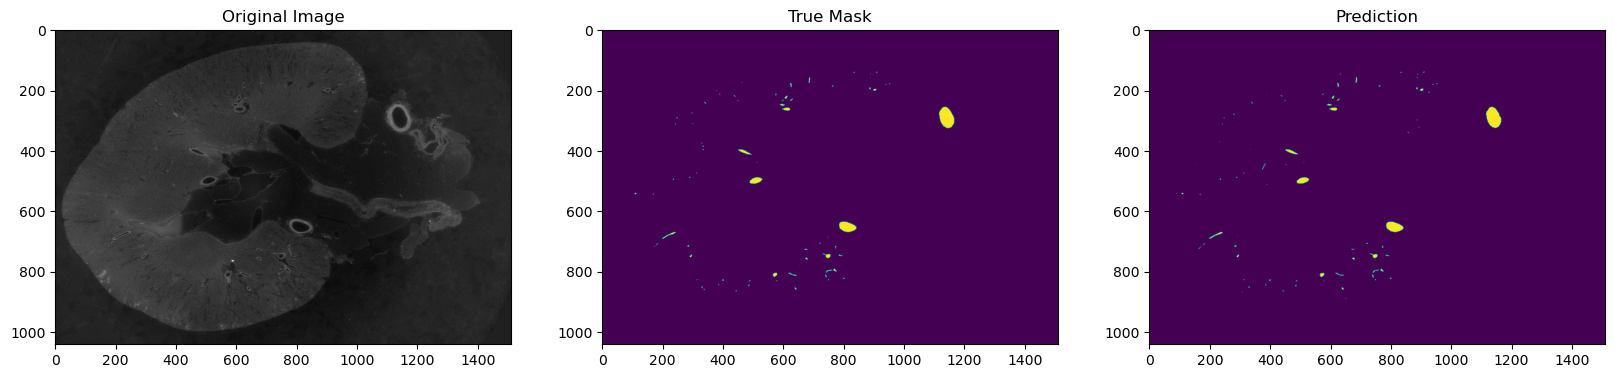

100%|██████████| 100/100 [00:00<00:00, 99959.58it/s]

INFERENCE SUCCESSFULL


In [189]:
"""
Coppied from https://www.kaggle.com/code/kashiwaba/sennet-hoa-inference-unet-simple-baseline
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tesd_dir = '/kaggle/input/blood-vessel-segmentation/test/'

def main():
    model = ImprovedUNet(in_channels=3, out_channels=1).to(device=device)
    load_checkpoint(torch.load(CHECKPOINT_DIR), model)
    
    # kidney_paths = glob(os.path.join(tesd_dir, 'kidney_*'))
#     kidney_paths = ['/kaggle/input/blood-vessel-segmentation/train/kidney_1_voi']
    
#     try:
#         save_predictions(kidney_paths, model, folder='', device=device)
#     except:
#         print('failure in saving and generating predictions')

    # kidney_names = [k.split('/')[-1] for k in kidney_paths]

    prediction_rles = inference(model, device, dataset_folder=VAL_DATASET_DIR, debug=True)

#     # Deleting the temporary files
#     for k in kidney_names:
#         shutil.rmtree(k, ignore_errors=True)

    prediction_rles.to_csv('submission.csv', index=False)
    
    print('INFERENCE SUCCESSFULL')


if __name__ == '__main__':
    main()